# 数据预处理

In [128]:
import pandas as pd #导入Pandas
df_sales = pd.read_csv('易速鲜花订单记录.csv') #载入数据
df_sales.head() #显示头几行数据  

,订单号,产品码,消费日期,产品说明,数量,单价,用户码,城市
0,536374,21258,6/1/2020 9:09,五彩玫瑰五支装,32,10.95,15100,北京
1,536376,22114,6/1/2020 9:32,茉莉花白色25枝,48,3.45,15291,上海
2,536376,21733,6/1/2020 9:32,教师节向日葵3枝尤加利5枝,64,2.55,15291,上海
3,536378,22386,6/1/2020 9:37,百合粉色10花苞,10,1.95,14688,北京
4,536378,85099C,6/1/2020 9:37,橙黄香槟色康乃馨,10,1.95,14688,北京


## 数据可视化

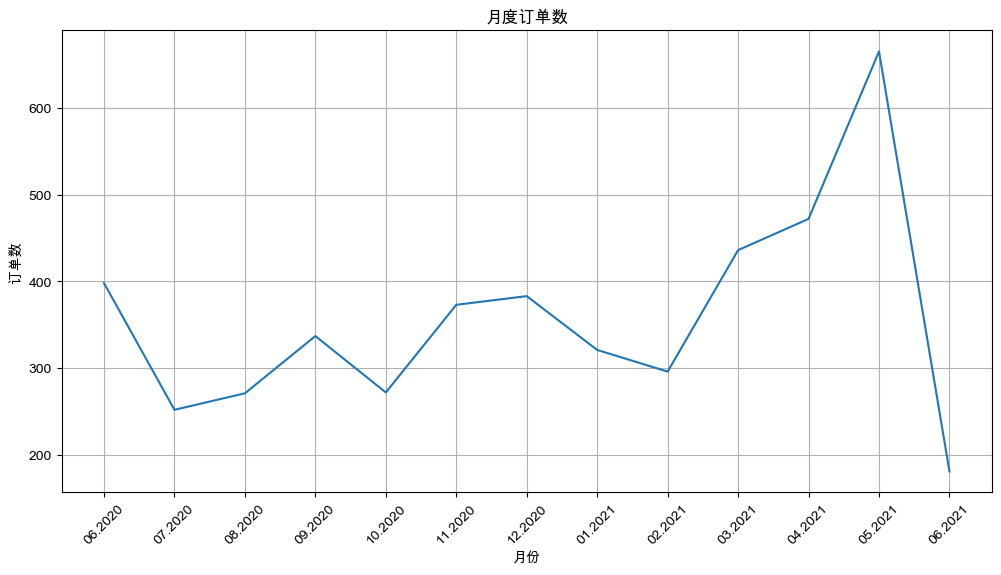

In [129]:
import matplotlib.pyplot as plt #导入Matplotlib的pyplot模块

# 设置中文字体，解决中文显示问题
plt.rcParams['font.sans-serif'] = ['Arial Unicode MS', 'PingFang SC', 'Heiti TC']  # macOS 中文字体
plt.rcParams['axes.unicode_minus'] = False  # 解决负号显示问题

#构建月度的订单数的DataFrame
df_sales['消费日期'] = pd.to_datetime(df_sales['消费日期']) #转化日期格式
df_orders_monthly = df_sales.set_index('消费日期')['订单号'].resample('ME').nunique() #每个月的订单数量
#设定绘图的画布
ax = pd.DataFrame(df_orders_monthly.values).plot(grid=True,figsize=(12,6),legend=False)
ax.set_xlabel('月份') # X轴label
ax.set_ylabel('订单数') # Y轴Label
ax.set_title('月度订单数') # 图题
#设定X轴月份显示格式
plt.xticks(
    range(len(df_orders_monthly.index)), 
    [x.strftime('%m.%Y') for x in df_orders_monthly.index], 
    rotation=45)
plt.show() # 绘图

## 数据清洗

In [130]:
df_sales = df_sales.drop_duplicates() #删除重复的数据行

In [131]:
df_sales.describe() #df_sales的统计信息

,消费日期,数量,单价,用户码
count,85920,85920.000000,85920.000000,85920.000000
mean,2021-01-04 22:50:58.891759616,10.115747,3.599711,15338.080389
min,2020-06-01 09:09:00,-9360.000000,0.000000,14681.000000
25%,2020-10-03 12:42:00,2.000000,1.250000,15022.000000
50%,2021-01-22 11:45:00,4.000000,1.950000,15334.000000
75%,2021-04-19 13:58:00,12.000000,3.750000,15673.000000
max,2021-06-09 12:31:00,3114.000000,38970.000000,16019.000000
std,NaN,49.114285,134.410498,391.309086


In [132]:
df_sales = df_sales.loc[df_sales['数量'] > 0] #清洗掉数量小于等于0的数据
df_sales.describe() #df_sales的统计信息

,消费日期,数量,单价,用户码
count,84112,84112.000000,84112.000000,84112.000000
mean,2021-01-05 01:14:46.564342784,10.760236,3.005032,15337.732963
min,2020-06-01 09:09:00,1.000000,0.000000,14681.000000
25%,2020-10-03 12:42:00,2.000000,1.250000,15021.000000
50%,2021-01-22 11:45:00,5.000000,1.950000,15333.000000
75%,2021-04-19 15:08:00,12.000000,3.750000,15674.000000
max,2021-06-09 12:31:00,3114.000000,3155.950000,16019.000000
std,NaN,34.018906,15.365085,392.074855


## 求 RFM 值

In [133]:
df_sales['总价'] = df_sales['数量'] * df_sales['单价'] #计算每单的总价
df_sales.head() #显示头几行数据       

,订单号,产品码,消费日期,产品说明,数量,单价,用户码,城市,总价
0,536374,21258,2020-06-01 09:09:00,五彩玫瑰五支装,32,10.95,15100,北京,350.4
1,536376,22114,2020-06-01 09:32:00,茉莉花白色25枝,48,3.45,15291,上海,165.6
2,536376,21733,2020-06-01 09:32:00,教师节向日葵3枝尤加利5枝,64,2.55,15291,上海,163.2
3,536378,22386,2020-06-01 09:37:00,百合粉色10花苞,10,1.95,14688,北京,19.5
4,536378,85099C,2020-06-01 09:37:00,橙黄香槟色康乃馨,10,1.95,14688,北京,19.5


### 构建用户层级表

In [134]:
df_user = pd.DataFrame(df_sales['用户码'].unique()) #生成以用户码为主键的结构df_user
df_user.columns = ['用户码'] #设定字段名
df_user = df_user.sort_values(by='用户码',ascending=True).reset_index(drop=True) #按用户码排序
df_user #显示df_user


,用户码
0,14681
1,14682
2,14684
3,14687
4,14688
...,...
975,16015
976,16016
977,16017
978,16018


### 求出 R 值

In [135]:
df_sales['消费日期'] = pd.to_datetime(df_sales['消费日期']) #转化日期格式
df_recent_buy = df_sales.groupby('用户码').消费日期.max().reset_index() #构建消费日期信息
df_recent_buy.columns = ['用户码','最近日期'] #设定字段名
df_recent_buy['R值'] = (df_recent_buy['最近日期'].max() - df_recent_buy['最近日期']).dt.days #计算最新日期与上次消费日期的天数
df_user = pd.merge(df_user, df_recent_buy[['用户码','R值']], on='用户码') #把上次消费距最新日期的天数（R值）合并至df_user结构
df_user.head() #显示df_user头几行数据

,用户码,R值
0,14681,70
1,14682,187
2,14684,25
3,14687,106
4,14688,7


### 求出 F 值

In [136]:
df_frequency = df_sales.groupby('用户码').消费日期.count().reset_index() #计算每个用户消费次数，构建df_frequency对象
df_frequency.columns = ['用户码','F值'] #设定字段名称
df_user = pd.merge(df_user, df_frequency, on='用户码') #把消费频率整合至df_user结构
df_user.head() #显示头几行数据

,用户码,R值,F值
0,14681,70,7
1,14682,187,2
2,14684,25,390
3,14687,106,15
4,14688,7,324


### 求出 M 值

In [137]:
df_revenue = df_sales.groupby('用户码').总价.sum().reset_index() #根据消费总额，构建df_revenue对象
df_revenue.columns = ['用户码','M值'] #设定字段名称
df_user = pd.merge(df_user, df_revenue, on='用户码') #把消费金额整合至df_user结构
df_user.head() #显示头几行数据

,用户码,R值,F值,M值
0,14681,70,7,498.95
1,14682,187,2,52.00
2,14684,25,390,1201.51
3,14687,106,15,628.38
4,14688,7,324,5579.10


<Axes: title={'center': '新进度分布直方图'}, ylabel='Frequency'>

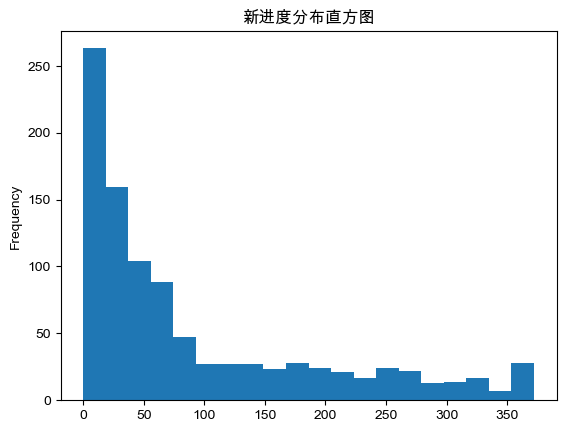

In [138]:
df_user['R值'].plot(kind='hist', bins=20, title = '新进度分布直方图') #R值直方图

<Axes: title={'center': '消费频率分布直方图'}, ylabel='Frequency'>

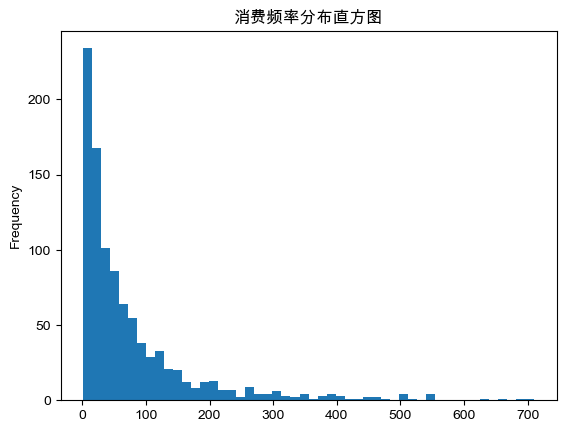

In [139]:
df_user.query('F值 < 800')['F值'].plot(kind='hist', bins=50, title = '消费频率分布直方图') #F值直方图

<Axes: title={'center': '消费金额分布直方图'}, ylabel='Frequency'>

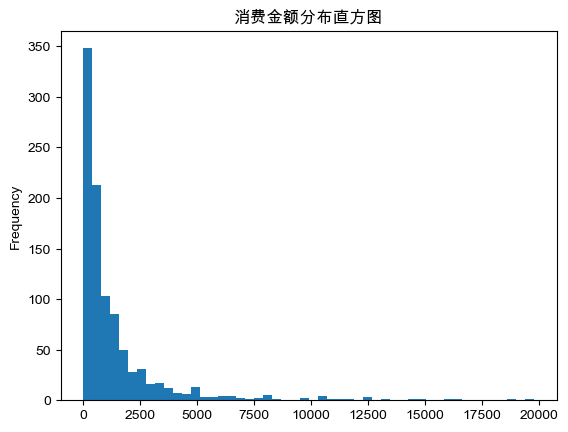

In [140]:
df_user.query('M值 < 20000')['M值'].plot(kind='hist', bins=50, title = '消费金额分布直方图') #M值直方图

# 聚类
## 手肘法

In [141]:
from sklearn.cluster import KMeans #导入KMeans模块
def show_elbow(df): #定义手肘函数
    distance_list = [] #聚质心的距离（损失）
    K = range(1,9) #K值范围
    for k in K:
        kmeans = KMeans(n_clusters=k, max_iter=100) #创建KMeans模型
        kmeans = kmeans.fit(df) #拟合模型
        distance_list.append(kmeans.inertia_) #创建每个K值的损失
    plt.plot(K, distance_list, 'bx-') #绘图
    plt.xlabel('k') #X轴
    plt.ylabel('距离均方误差') #Y轴
    plt.title('k值手肘图') #标题

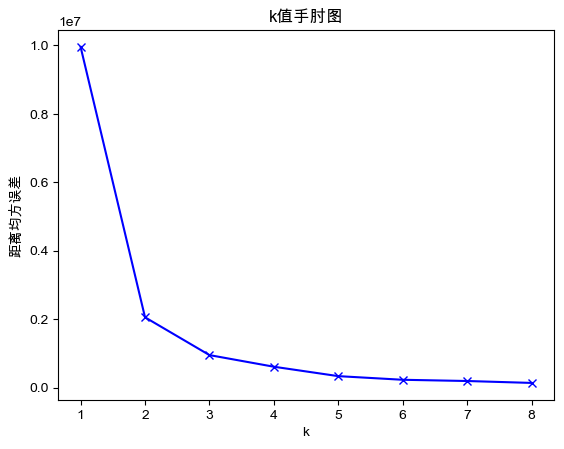

In [142]:
show_elbow(df_user[['R值']]) #显示R值聚类K值手肘图

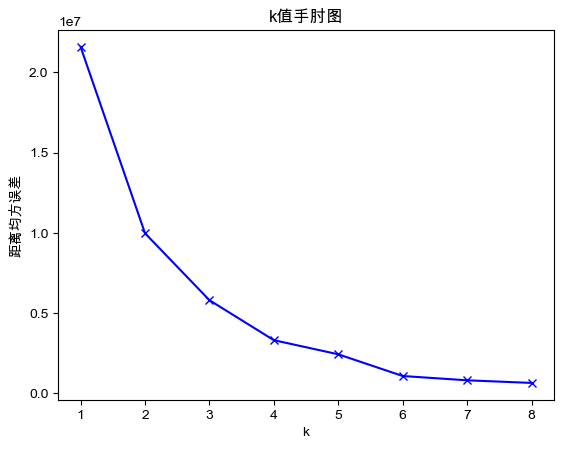

In [143]:
show_elbow(df_user[['F值']]) #显示F值聚类K值手肘图

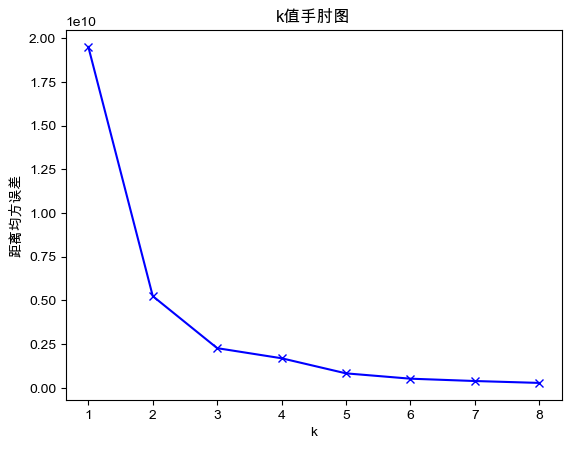

In [144]:
show_elbow(df_user[['M值']]) #显示M值聚类K值手肘图

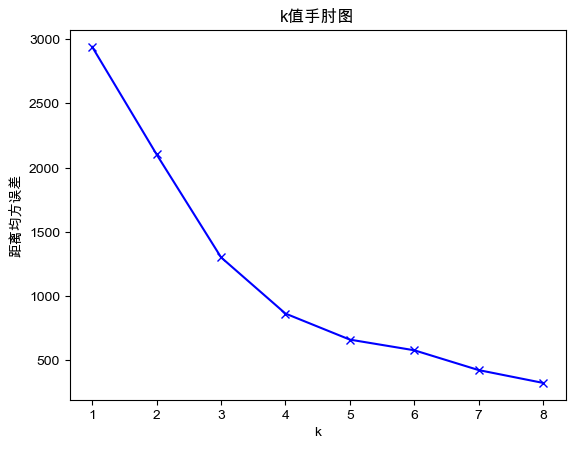

In [145]:
from sklearn.preprocessing import StandardScaler
# 1. 数据标准化（重要！因为R、F、M量纲不同）
scaler = StandardScaler()
df_RFM_scaled = scaler.fit_transform(df_user[['R值', 'F值', 'M值']])
df_user[['R值_scaled', 'F值_scaled', 'M值_scaled']] = df_RFM_scaled

show_elbow(df_RFM_scaled)

## 创建和训练模型

In [146]:
from sklearn.cluster import KMeans #导入KMeans模块
kmeans_R = KMeans(n_clusters=3) #设定K=3
kmeans_F = KMeans(n_clusters=4) #设定K=4
kmeans_M = KMeans(n_clusters=4) #设定K=4
kmeans_RFM = KMeans(n_clusters=5)

kmeans_R.fit(df_user[['R值']]) #拟合模型
kmeans_F.fit(df_user[['F值']]) #拟合模型
kmeans_M.fit(df_user[['M值']]) #拟合模型
kmeans_RFM.fit(df_RFM_scaled) #拟合模型

,"n_clusters n_clusters: int, default=8The number of clusters to form as well as the number ofcentroids to generate.For an example of how to choose an optimal value for `n_clusters` refer to:ref:`sphx_glr_auto_examples_cluster_plot_kmeans_silhouette_analysis.py`.",5
,"init init: {'k-means++', 'random'}, callable or array-like of shape (n_clusters, n_features), default='k-means++'Method for initialization:* 'k-means++' : selects initial cluster centroids using sampling based on an empirical probability distribution of the points' contribution to the overall inertia. This technique speeds up convergence. The algorithm implemented is ""greedy k-means++"". It differs from the vanilla k-means++ by making several trials at each sampling step and choosing the best centroid among them.* 'random': choose `n_clusters` observations (rows) at random from data for the initial centroids.* If an array is passed, it should be of shape (n_clusters, n_features) and gives the initial centers.* If a callable is passed, it should take arguments X, n_clusters and a random state and return an initialization.For an example of how to use the different `init` strategies, see:ref:`sphx_glr_auto_examples_cluster_plot_kmeans_digits.py`.For an evaluation of the impact of initialization, see the example:ref:`sphx_glr_auto_examples_cluster_plot_kmeans_stability_low_dim_dense.py`.",'k-means++'
,"n_init n_init: 'auto' or int, default='auto'Number of times the k-means algorithm is run with different centroidseeds. The final results is the best output of `n_init` consecutive runsin terms of inertia. Several runs are recommended for sparsehigh-dimensional problems (see :ref:`kmeans_sparse_high_dim`).When `n_init='auto'`, the number of runs depends on the value of init:10 if using `init='random'` or `init` is a callable;1 if using `init='k-means++'` or `init` is an array-like... versionadded:: 1.2 Added 'auto' option for `n_init`... versionchanged:: 1.4 Default value for `n_init` changed to `'auto'`.",'auto'
,"max_iter max_iter: int, default=300Maximum number of iterations of the k-means algorithm for asingle run.",300
,"tol tol: float, default=1e-4Relative tolerance with regards to Frobenius norm of the differencein the cluster centers of two consecutive iterations to declareconvergence.",0.0001
,"verbose verbose: int, default=0Verbosity mode.",0
,"random_state random_state: int, RandomState instance or None, default=NoneDetermines random number generation for centroid initialization. Usean int to make the randomness deterministic.See :term:`Glossary `.",None
,"copy_x copy_x: bool, default=TrueWhen pre-computing distances it is more numerically accurate to centerthe data first. If copy_x is True (default), then the original data isnot modified. If False, the original data is modified, and put backbefore the function returns, but small numerical differences may beintroduced by subtracting and then adding the data mean. Note that ifthe original data is not C-contiguous, a copy will be made even ifcopy_x is False. If the original data is sparse, but not in CSR format,a copy will be made even if copy_x is False.",True
,"algorithm algorithm: {""lloyd"", ""elkan""}, default=""lloyd""K-means algorithm to use. The classical EM-style algorithm is `""lloyd""`.The `""elkan""` variation can be more efficient on some datasets withwell-defined clusters, by using the triangle inequality. However it'smore memory intensive due to the allocation of an extra array of shape`(n_samples, n_clusters)`... versionchanged:: 0.18 Added Elkan algorithm.. versionchanged:: 1.1 Renamed ""full"" to ""lloyd"", and deprecated ""auto"" and ""full"". Changed ""auto"" to use ""lloyd"" instead of ""elkan"".",'lloyd'


## 使用模型进行聚类，并给用户分组

In [147]:
df_user['R值层级'] = kmeans_R.predict(df_user[['R值']]) #通过聚类模型求出R值的层级
df_user.head() #显示头几行数据

,用户码,R值,F值,M值,R值_scaled,F值_scaled,M值_scaled,R值层级
0,14681,70,7,498.95,-0.220966,-0.531261,-0.267767,2
1,14682,187,2,52.00,0.940221,-0.564958,-0.367973,0
2,14684,25,390,1201.51,-0.667576,2.049946,-0.110253,2
3,14687,106,15,628.38,0.136322,-0.477345,-0.238748,0
4,14688,7,324,5579.10,-0.846220,1.605143,0.871204,2


In [148]:
df_user.groupby('R值层级')['R值'].describe() #R值层级分组统计信息

,count,mean,std,min,25%,50%,75%,max
R值层级,,,,,,,,
0,178.0,157.162921,37.340870,95.0,126.00,156.5,188.75,225.0
1,138.0,298.094203,45.436550,231.0,255.25,292.5,334.50,372.0
2,664.0,32.088855,25.141763,0.0,10.00,25.0,50.00,94.0


In [149]:
#定义一个order_cluster函数为聚类排序
def order_cluster(cluster_name, target_name,df,ascending=False):
    df_new = df.groupby(cluster_name)[target_name].mean().reset_index() #按聚类结果分组，创建df_new对象
    df_new = df_new.sort_values(by=target_name,ascending=ascending).reset_index(drop=True) #排序
    df_new['index'] = df_new.index #创建索引字段
    df_new = pd.merge(df,df_new[[cluster_name,'index']], on=cluster_name) #基于聚类名称把df_new还原为df对象，并添加索引字段
    df_new = df_new.drop([cluster_name],axis=1) #删除聚类名称
    df_new = df_new.rename(columns={"index":cluster_name}) #将索引字段重命名为聚类名称字段
    return df_new #返回排序后的df_new对象

In [150]:
df_user = order_cluster('R值层级', 'R值', df_user, False) #调用簇排序函数
df_user = df_user.sort_values(by='用户码',ascending=True).reset_index(drop=True) #根据用户码排序
df_user.head() #显示头几行数据

,用户码,R值,F值,M值,R值_scaled,F值_scaled,M值_scaled,R值层级
0,14681,70,7,498.95,-0.220966,-0.531261,-0.267767,2
1,14682,187,2,52.00,0.940221,-0.564958,-0.367973,1
2,14684,25,390,1201.51,-0.667576,2.049946,-0.110253,2
3,14687,106,15,628.38,0.136322,-0.477345,-0.238748,1
4,14688,7,324,5579.10,-0.846220,1.605143,0.871204,2


In [151]:
df_user.groupby('R值层级')['R值'].describe() #R值层级分组统计信息

,count,mean,std,min,25%,50%,75%,max
R值层级,,,,,,,,
0,138.0,298.094203,45.436550,231.0,255.25,292.5,334.50,372.0
1,178.0,157.162921,37.340870,95.0,126.00,156.5,188.75,225.0
2,664.0,32.088855,25.141763,0.0,10.00,25.0,50.00,94.0


In [152]:
df_user['F值层级'] = kmeans_F.predict(df_user[['F值']]) #通过聚类模型求出F值的层级
df_user = order_cluster('F值层级', 'F值',df_user,True) #调用簇排序函数
df_user.groupby('F值层级')['F值'].describe() #F值层级分组统计信息

,count,mean,std,min,25%,50%,75%,max
F值层级,,,,,,,,
0,861.0,47.289199,41.413724,1.0,14.0,33.0,70.0,170.0
1,109.0,296.899083,108.981560,173.0,205.0,266.0,364.0,628.0
2,9.0,963.111111,264.100570,662.0,710.0,931.0,1112.0,1477.0
3,1.0,2366.000000,NaN,2366.0,2366.0,2366.0,2366.0,2366.0


In [153]:
df_user = df_user.sort_values(by='用户码',ascending=True).reset_index(drop=True) #根据用户码排序
df_user.head()

,用户码,R值,F值,M值,R值_scaled,F值_scaled,M值_scaled,R值层级,F值层级
0,14681,70,7,498.95,-0.220966,-0.531261,-0.267767,2,0
1,14682,187,2,52.00,0.940221,-0.564958,-0.367973,1,0
2,14684,25,390,1201.51,-0.667576,2.049946,-0.110253,2,1
3,14687,106,15,628.38,0.136322,-0.477345,-0.238748,1,0
4,14688,7,324,5579.10,-0.846220,1.605143,0.871204,2,1


In [154]:
df_user['M值层级'] = kmeans_M.predict(df_user[['M值']]) #通过聚类模型求出M值的层级
df_user = order_cluster('M值层级', 'M值',df_user,True) #调用簇排序函数
df_user.groupby('M值层级')['M值'].describe() #M值层级分组统计信息
df_user = df_user.sort_values(by='用户码',ascending=True).reset_index(drop=True) #根据用户码排序
df_user.head() #显示头几行数据

,用户码,R值,F值,M值,R值_scaled,F值_scaled,M值_scaled,R值层级,F值层级,M值层级
0,14681,70,7,498.95,-0.220966,-0.531261,-0.267767,2,0,0
1,14682,187,2,52.00,0.940221,-0.564958,-0.367973,1,0,0
2,14684,25,390,1201.51,-0.667576,2.049946,-0.110253,2,1,0
3,14687,106,15,628.38,0.136322,-0.477345,-0.238748,1,0,0
4,14688,7,324,5579.10,-0.846220,1.605143,0.871204,2,1,1


## 为用户整体分组画像

In [155]:
df_user['总分'] = df_user['R值层级'] + df_user['F值层级'] + df_user['M值层级'] #求出每个用户RFM总分

In [156]:
#在df_user对象中添加总体价值这个字段
df_user.loc[(df_user['总分']<=2) & (df_user['总分']>=0), '总体价值'] = '低价值' 
df_user.loc[(df_user['总分']<=4) & (df_user['总分']>=3), '总体价值'] = '中价值' 
df_user.loc[(df_user['总分']<=8) & (df_user['总分']>=5), '总体价值'] = '高价值'
df_user #显示df_user

,用户码,R值,F值,M值,R值_scaled,F值_scaled,M值_scaled,R值层级,F值层级,M值层级,总分,总体价值
0,14681,70,7,498.95,-0.220966,-0.531261,-0.267767,2,0,0,2,低价值
1,14682,187,2,52.00,0.940221,-0.564958,-0.367973,1,0,0,1,低价值
2,14684,25,390,1201.51,-0.667576,2.049946,-0.110253,2,1,0,3,中价值
3,14687,106,15,628.38,0.136322,-0.477345,-0.238748,1,0,0,1,低价值
4,14688,7,324,5579.10,-0.846220,1.605143,0.871204,2,1,1,4,中价值
...,...,...,...,...,...,...,...,...,...,...,...,...
975,16015,3,181,704.55,-0.885919,0.641402,-0.221671,2,1,0,3,中价值
976,16016,2,224,1465.51,-0.895843,0.931198,-0.051064,2,1,0,3,中价值
977,16017,46,32,211.88,-0.459158,-0.362775,-0.332128,2,0,0,2,低价值
978,16018,38,28,408.90,-0.538555,-0.389732,-0.287956,2,0,0,2,低价值


In [157]:
print(df_user['总分'])

0      2
1      1
2      3
3      1
4      4
      ..
975    3
976    3
977    2
978    2
979    3
Name: 总分, Length: 980, dtype: int64


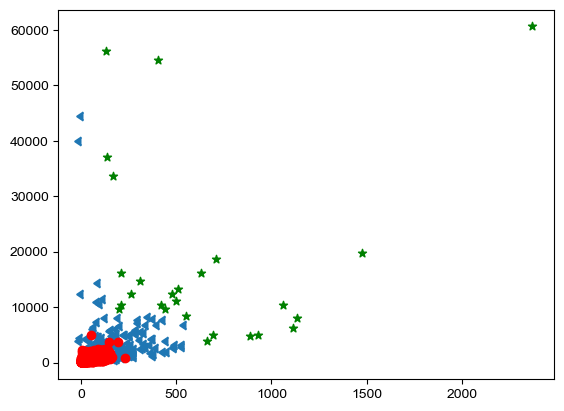

In [158]:
#显示高、中、低价值组分布散点图（F值与M值）
plt.scatter(df_user.query("总体价值 == '高价值'")['F值'],
                   df_user.query("总体价值 == '高价值'")['M值'],c='g',marker='*')
plt.scatter(df_user.query("总体价值 == '中价值'")['F值'],
                   df_user.query("总体价值 == '中价值'")['M值'],marker=8)
plt.scatter(df_user.query("总体价值 == '低价值'")['F值'],
                   df_user.query("总体价值 == '低价值'")['M值'],c='r')


In [159]:
df_user['RFM值层级'] = kmeans_M.fit_predict(df_RFM_scaled)
df_user['RFM综合得分'] = -df_user['R值_scaled'] + df_user['F值_scaled'] + df_user['M值_scaled']

df_user = order_cluster('RFM值层级', 'RFM综合得分', df_user, ascending=True)
df_user.head(50)

,用户码,R值,F值,M值,R值_scaled,F值_scaled,M值_scaled,R值层级,F值层级,M值层级,总分,总体价值,RFM综合得分,RFM值层级
0,14681,70,7,498.95,-0.220966,-0.531261,-0.267767,2,0,0,2,低价值,-0.578062,1
1,14682,187,2,52.00,0.940221,-0.564958,-0.367973,1,0,0,1,低价值,-1.873152,0
2,14684,25,390,1201.51,-0.667576,2.049946,-0.110253,2,1,0,3,中价值,2.607269,2
3,14687,106,15,628.38,0.136322,-0.477345,-0.238748,1,0,0,1,低价值,-0.852416,1
4,14688,7,324,5579.10,-0.846220,1.605143,0.871204,2,1,1,4,中价值,3.322567,2
5,14689,208,13,112.80,1.148639,-0.490824,-0.354342,1,0,0,1,低价值,-1.993805,0
6,14690,43,48,355.05,-0.488932,-0.254943,-0.300029,2,0,0,2,低价值,-0.066041,1
7,14691,30,71,2114.33,-0.617953,-0.099936,0.094402,2,0,0,2,低价值,0.612418,1
8,14692,136,68,591.55,0.434063,-0.120155,-0.247006,1,0,0,1,低价值,-0.801223,1
9,14693,263,8,172.90,1.694496,-0.524521,-0.340867,0,0,0,0,低价值,-2.559885,0


In [160]:
df_user[df_user['RFM值层级'] == 3]

,用户码,R值,F值,M值,R值_scaled,F值_scaled,M值_scaled,R值层级,F值层级,M值层级,总分,总体价值,RFM综合得分,RFM值层级
268,15061,3,403,54534.14,-0.885919,2.137559,11.846939,2,1,3,6,高价值,14.870417,3
296,15098,181,3,39916.50,0.880673,-0.558218,8.569660,1,0,3,4,中价值,7.130769,3
461,15311,0,2366,60632.75,-0.915693,15.367085,13.214249,2,3,3,8,高价值,29.497027,3
787,15749,234,10,44534.30,1.406681,-0.511042,9.604972,0,0,3,3,中价值,7.687249,3
802,15769,6,130,56252.72,-0.856145,0.297691,12.232245,2,0,3,5,高价值,13.386081,3
855,15838,10,167,33643.08,-0.816446,0.547050,7.163157,2,0,3,5,高价值,8.526654,3
973,16013,3,139,37130.60,-0.885919,0.358346,7.945060,2,0,3,5,高价值,9.189325,3


In [161]:
import plotly.express as px

# 创建交互式3D散点图
fig = px.scatter_3d(
    df_user, 
    x='F值', 
    y='R值', 
    z='M值',
    color='RFM值层级',
    color_continuous_scale='Reds',  # 红色渐变
    title='RFM用户价值3D分布',
    labels={'RFM值层级': '价值层级'}
)

fig.update_traces(marker=dict(size=3))  # 默认是8左右，改成3会小很多

fig.show()